In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'semantic-drone-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F333968%2F1834160%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T120016Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D52cbfd47999ad9599ba1d19ff36ea7d09d7699cfcf4e8f1eec42a7b3604bae9b7831e65d33f6e7dc5707b974c3291f6bdb2ac2241eb2ee62e88a94e6c38c312f8ed28a1a3c8a944ad4af643e85721dc2da75a1892d775852ee637ac9abe34b792beabd3e32afb27a284d958620deb35d29b149e41a9cbc0e447737dd0be35995381bc9e06c14445e58c95c18f655e92dac5d900099dff95ed012889e3f50d0fad6f741d2e5175482dba0c325f17c4cae7a3e6899f86cff26b330bc5163de31045e62dd71ee710d0450841c67076203bfe58cc2133425cf0abdcff7335a61706ed11e56da3333d078626febb69224f3802c15a12ddfbc7e7a84353c6a660ccd03'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4174531957 bytes downloaded
Downloaded and uncompressed: semantic-drone-dataset
Data source import complete.


<a id="top"></a>
# <div style="padding:30px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:20px;background-color:#112A90;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:Purple; padding:30px;border-radius:15px; font-size:15px;color:#d6d6d6">
    
<a id="TOC"></a>
## Guide and table of contents
    
* [Import list of required libraries and configurations](#lib)
* [Information and codes related to the dataset](#2)
* [Split Data](#3)
* [Data Preprocessing](#4)
* [Display classification for images](#5)
* [Initialize a Model](#7)
* [Trainnig and model fit](#8)
* [Model Evaluation](#9)


<a id="lib"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Import list of required libraries and configurations</b></div>

# Introduction

What is the difference between **SegNet** and **U-Net**? Which one is suitable for the semantic division of the images taken by the drone?

SegNet and U-Net are two popular architectures for semantic segmentation tasks in computer vision, and both are widely used for dividing images taken by drones. However, they have different structures and capabilities.


# Install packages

First, we have to install packages to conduct image segmentation with Keras.

In [2]:
import os
import sys
import time
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Read CSV File

This csv file contains information as to **different classes of objects** that might be included in each image. Each class of object must have **a different color for distinction of different kinds of objects**. This table shows the corresponding colors to each class of object by the RGB values.

In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df.head()

name    r    g    b
0   unlabeled    0    0    0
1  paved-area  128   64  128
2        dirt  130   76    0
3       grass    0  102    0
4      gravel  112  103   87

In [4]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')

# Display all categories
print(df)

           name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0


In [5]:
from IPython.display import HTML

labels = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
labels

# Define CSS properties for styling the table
styles = [
    {'selector': 'th', 'props': [('font-size', '20px'), ('text-align', 'center'), ('background-color', '#112A07') ]},
    {'selector': 'td', 'props': [('font-size', '17px'), ('text-align', 'center')]},
]

# Create a Styler object and apply the CSS styles
styled_output_df = labels.style.set_table_styles(styles)

# Set the table title
table_title = "<h2>Data classification</h2>"

# Display the table with the title
display(HTML(table_title))
display(styled_output_df)

In [6]:
df.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

In [7]:
class_list = df.name.values.tolist()
print(class_list)
len(class_list)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


24

# Sample Images

It is important to see one or several sample original images as well as annotated images. They can be shown in the same way and in a pair. In addition, we should check the data size of these images.

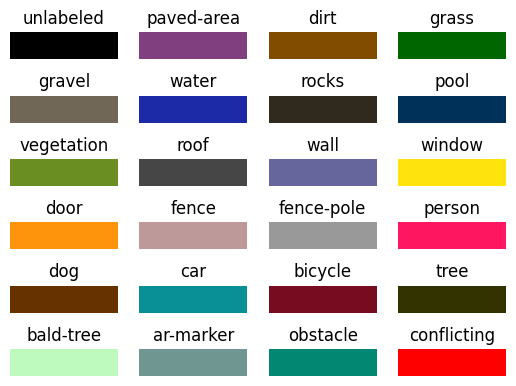

In [8]:
def print_label_colors():
    '''
    This method is just to print the label and their colors for reference
    '''
    for index,label in enumerate(labels.name):
        plt.subplot(6,4,index+1)
        (r,g,b)=labels.iloc[index].values[1:]
        img_ = np.array([[[r,g,b],[r,g,b],[r,g,b],[r,g,b]]])
        plt.title(label)
        plt.imshow(img_)
        plt.axis('off')
print_label_colors()

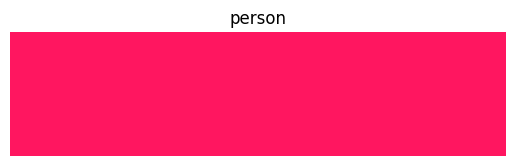

In [9]:
def print_label_colors():
    '''
    This method is just to print the label and their colors for reference
    '''
    for index, label in enumerate(labels.name):
        if label == 'person':  # Display only the person class
            plt.subplot(1, 1, 1)  # Use a single subplot
            (r, g, b) = labels.iloc[index].values[1:]
            img_ = np.array([[[r, g, b], [r, g, b], [r, g, b], [r, g, b]]])
            plt.title(label)
            plt.imshow(img_)
            plt.axis('off')

print_label_colors()

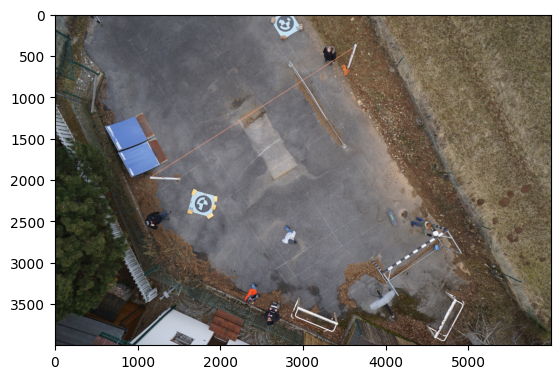

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# original image
image = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/001.jpg')
image = np.array(image)
plt.imshow(image)

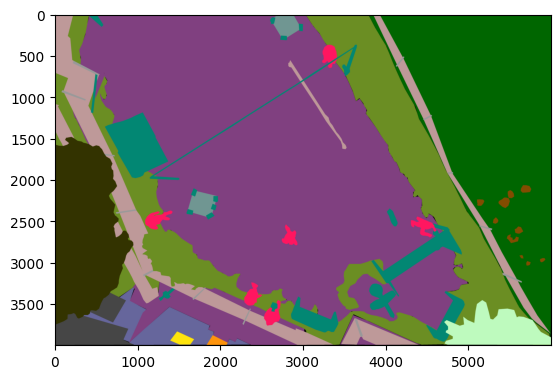

In [11]:
# mask image
mask = Image.open('/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/001.png')
mask = np.array(mask)
plt.imshow(mask)

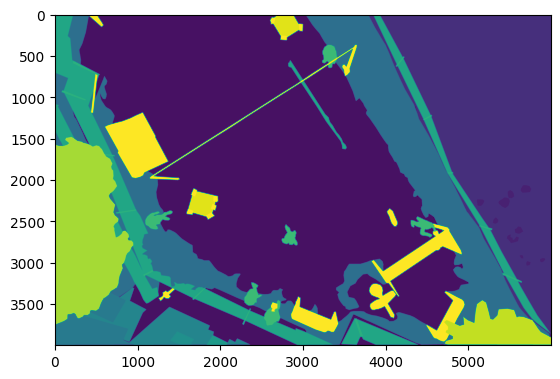

In [12]:
# label image
label = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/001.png')
label = np.array(label)
plt.imshow(label)

In [13]:
image.shape, label.shape

((4000, 6000, 3), (4000, 6000))

In [14]:
image.min(), image.max()

(0, 255)

In [15]:
label.min(), label.max()

(0, 22)

Text(0.5, 1.0, 'Label Image')

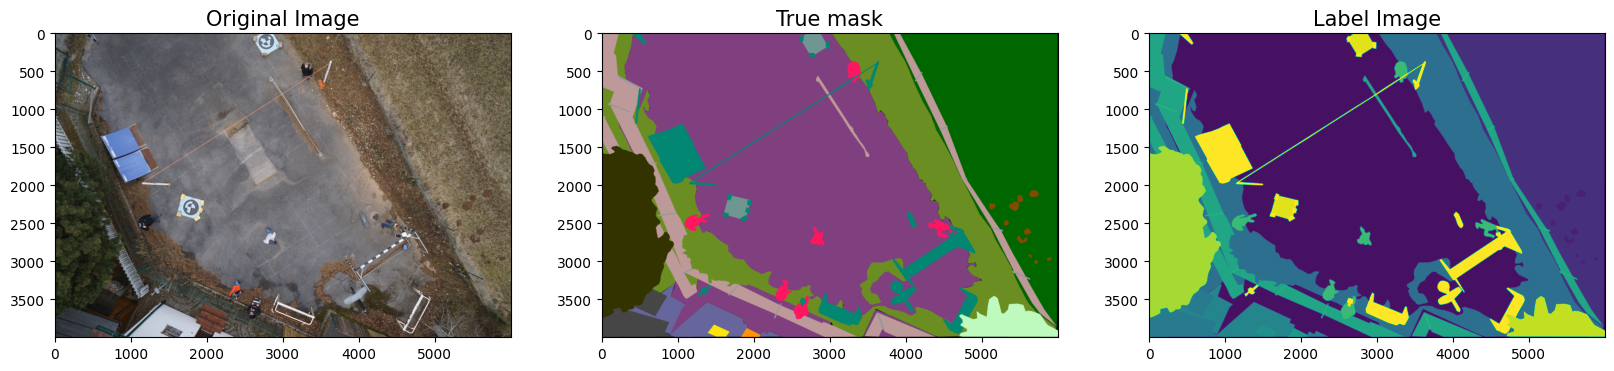

In [16]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image", fontsize=15)

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title("True mask", fontsize=15)

plt.subplot(1, 3, 3)
plt.imshow(label)
plt.title("Label Image", fontsize=15)

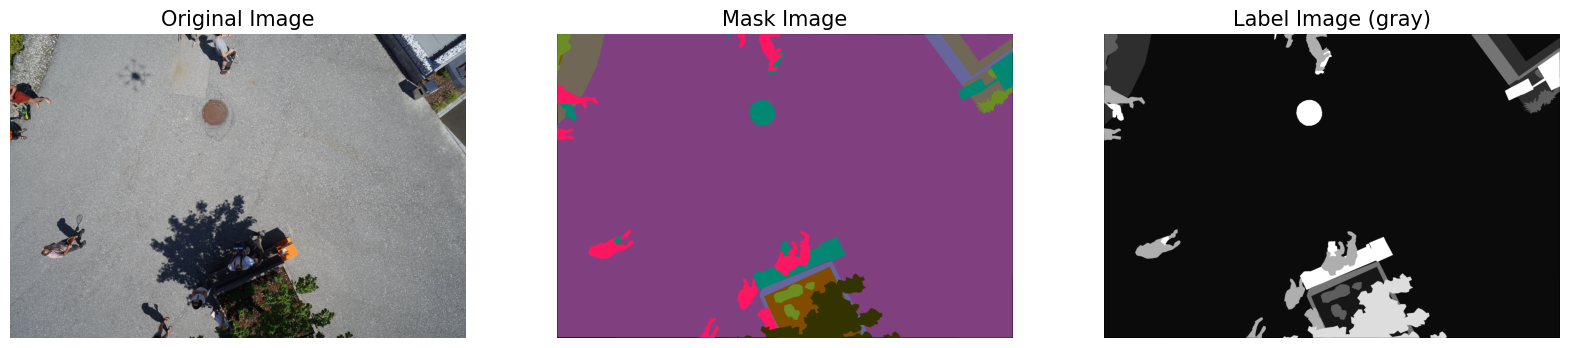

In [17]:
# Corrected file paths
image_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg'
image_mask_path = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png'
image_label_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png'

# Load the images
image = Image.open(image_path)
image_mask = Image.open(image_mask_path)
image_label = Image.open(image_label_path)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(image)
axes[0].set_title("Original Image", fontsize=15)
axes[0].axis('off')
axes[1].imshow(image_mask)
axes[1].set_title("Mask Image", fontsize=15)
axes[1].axis('off')
axes[2].imshow(image_label, cmap='gray')
axes[2].set_title("Label Image (gray)", fontsize=15)
axes[2].axis('off')

plt.show()

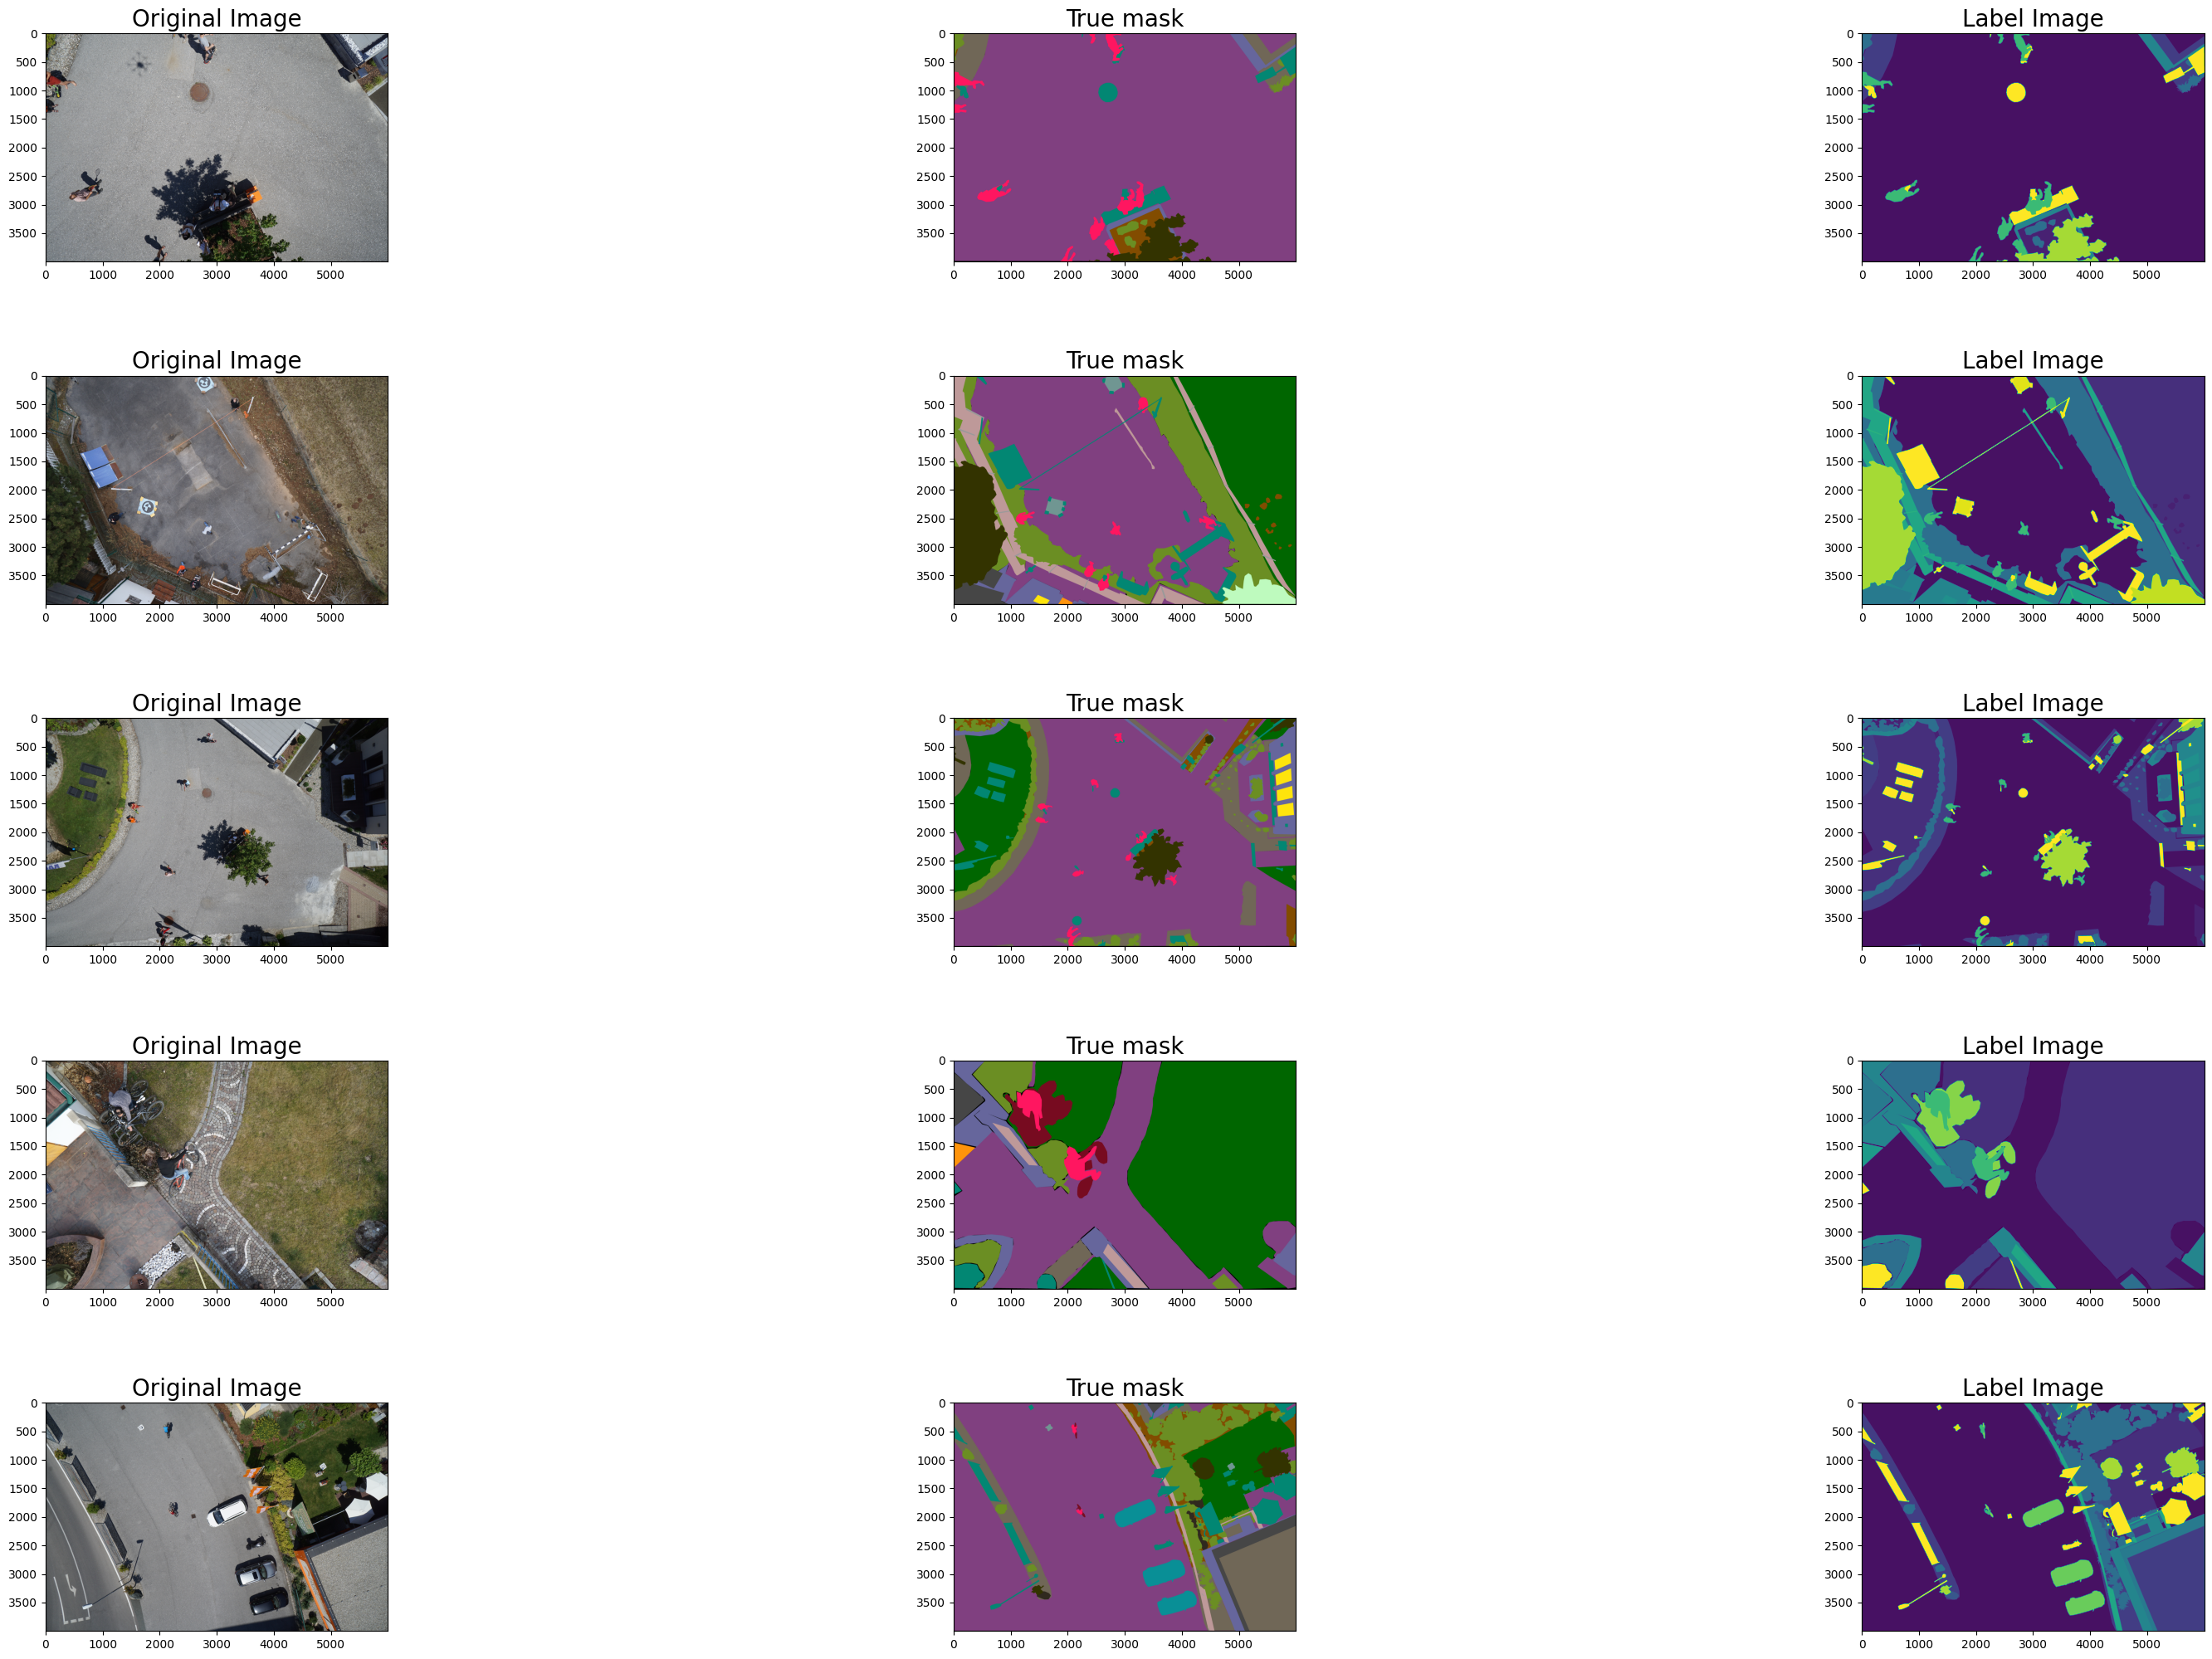

In [18]:
# 5 pairs of original and label images
n_max_imgs = 5

plt.figure(figsize = (40, 25))
for n in range(n_max_imgs):

    image = Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/00{n}.jpg')
    image = np.array(image)

    mask = Image.open(f'/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/00{n}.png')
    mask = np.array(mask)


    label = Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/00{n}.png')
    label = np.array(label)

    plt.subplot(n_max_imgs, 3, 3 * n + 1)
    plt.imshow(image)
    plt.title("Original Image", fontsize=20)
    plt.subplots_adjust(hspace=0.5)


    plt.subplot(n_max_imgs, 3, 3 * n + 2)
    plt.imshow(mask)
    plt.title("True mask", fontsize=20)


    plt.subplot(n_max_imgs, 3, 3 * n + 3)
    plt.imshow(label)
    plt.title("Label Image", fontsize=20)

<a id="2"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Information and codes related to the dataset
</b></div>

# Take the Paths for the Data Images

It is possible to create a list consisting paths for data images as to the original images and the annotation images, respectively. In fact, this process is suitable for segmentation with PyTorch but not so much with Keras. But we can see at least the number of these images.

In [19]:
from glob import glob
images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))
#print(images)

In [20]:
len(images)

400

In [21]:
labels = sorted(glob('/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/*.png'))
#print(labels)

In [22]:
len(mask)

4000

In [23]:
labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))
#print(labels)

In [24]:
len(labels)

400

<a id="3"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Split Data</b></div>

# Divide the Data into Training and Validation and Test Datasets

Like other kinds of machine learning, data must be divided into training data and validation data to **prevent overfitting**. Data can also be divided into training, validation and testing data.

In [25]:
from IPython.display import YouTubeVideo
import albumentations as A

# Set environment settings and pandas display options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Setting styles
sns.set_style('darkgrid')

# Warning settings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print('All modules have been imported')

All modules have been imported


In [26]:
IMAGE_PATH = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
MASK_PATH = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.15, random_state=19) # 15% for test
X_train, X_val = train_test_split(X_trainval, test_size=0.1745, random_state=19)  # 15% of 85% = 0.1765 or 17.65%

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))



Total Images:  400
Train Size   :  280
Val Size     :  60
Test Size    :  60


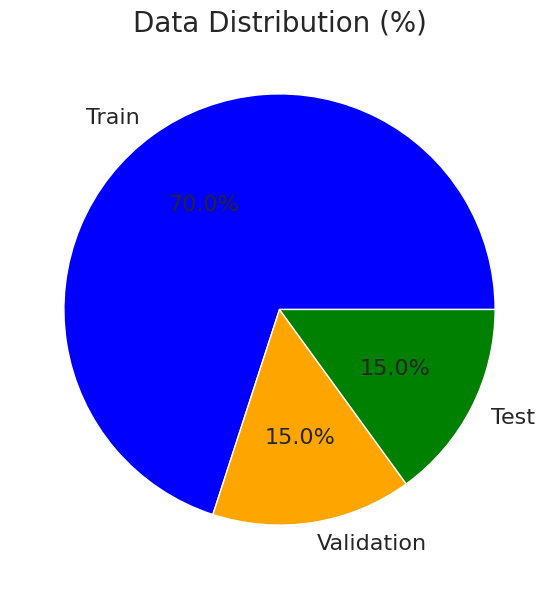

In [27]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np

# Increase the font of the chart entries
plt.rcParams.update({'font.size': 16})

IMAGE_PATH = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
MASK_PATH = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
total_images = len(df)

# Split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.15, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.1745, random_state=19)

# Calculate percentages
train_percent = (len(X_train) / total_images) * 100
val_percent = (len(X_val) / total_images) * 100
test_percent = (len(X_test) / total_images) * 100

# Display data with increased font size
display_data = pd.DataFrame({
    'Data Split': ['Train', 'Validation', 'Test'],
    'Size': [len(X_train), len(X_val), len(X_test)],
    'Percentage': [f"{train_percent:.2f}%", f"{val_percent:.2f}%", f"{test_percent:.2f}%"]
})

display(HTML(display_data.to_html(index=False).replace('<table', '<table style="font-size:20px"')))

# Displaying as a pie chart
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Data Distribution (%)', fontsize=20)
plt.show()



<a id="4"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Data Preprocessing</b></div>

In [28]:
image_directory = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
mask_directory = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

# Assuming that the images and masks have the same names
image_files = os.listdir(image_directory)
mask_files = os.listdir(mask_directory)

# Create a list to store the image file paths and corresponding labels
data = []

for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    mask_file = image_file.replace(".jpg", ".png")  # Assuming masks have .png extension
    mask_path = os.path.join(mask_directory, mask_file)

    # Load the mask as an RGB image
    mask = cv2.imread(mask_path)

    # Convert the mask to RGB format for comparison
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Check if the mask contains a person (RGB value [255, 22, 96])
    is_person = 1 if np.any(np.all(mask_rgb == [255, 22, 96], axis=-1)) else 0

    data.append((image_path, is_person))

In [29]:
df = pd.DataFrame(data, columns=["filepaths", "labels"])
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

filepaths  \
0  /kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/063.jpg   
1  /kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/006.jpg   
2  /kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/041.jpg   
3  /kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/229.jpg   
4  /kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/544.jpg   

  labels  
0      1  
1      1  
2      1  
3      1  
4      1

In [30]:
df.labels.unique()

array(['1', '0'], dtype=object)

In [31]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  320   test_df length:  40   valid_df length:  40


In [32]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

labels
1    294
0     26
Name: count, dtype: int64


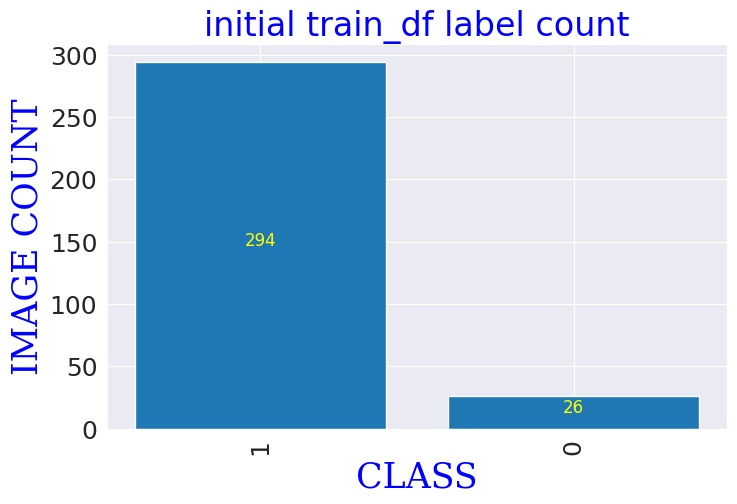

In [33]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train_df label count'
plot_label_count (train_df, plot_title)

In [34]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=100
min_samples= 10
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  320  with  2  classes
after trimming, the maximum samples in any class is now  100  and the minimum samples in any class is  10
the trimmed dataframe now is of length  126  with  2  classes


In [35]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=1000
working_dir=r'/kaggle/working/'
img_size = (310,640)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  126


augmenting class 1:   0%|                                                                    | 0/900 [00:00<?,…

augmenting class 0:   0%|                                                                    | 0/974 [00:00<?,…

Total Augmented images created=  1874
Length of augmented dataframe is now  2000


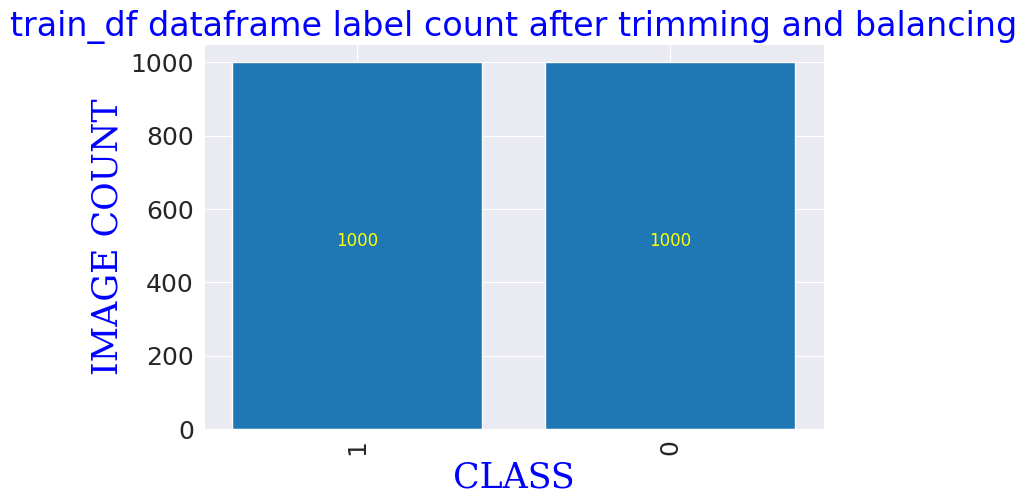

In [36]:
plot_title='train_df dataframe label count after trimming and balancing'
plot_label_count (train_df, plot_title)

In [37]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=16
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 2000 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
test batch size:  40   test steps:  1  number of classes :  2


<a id="5"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Display classification for images</b></div>

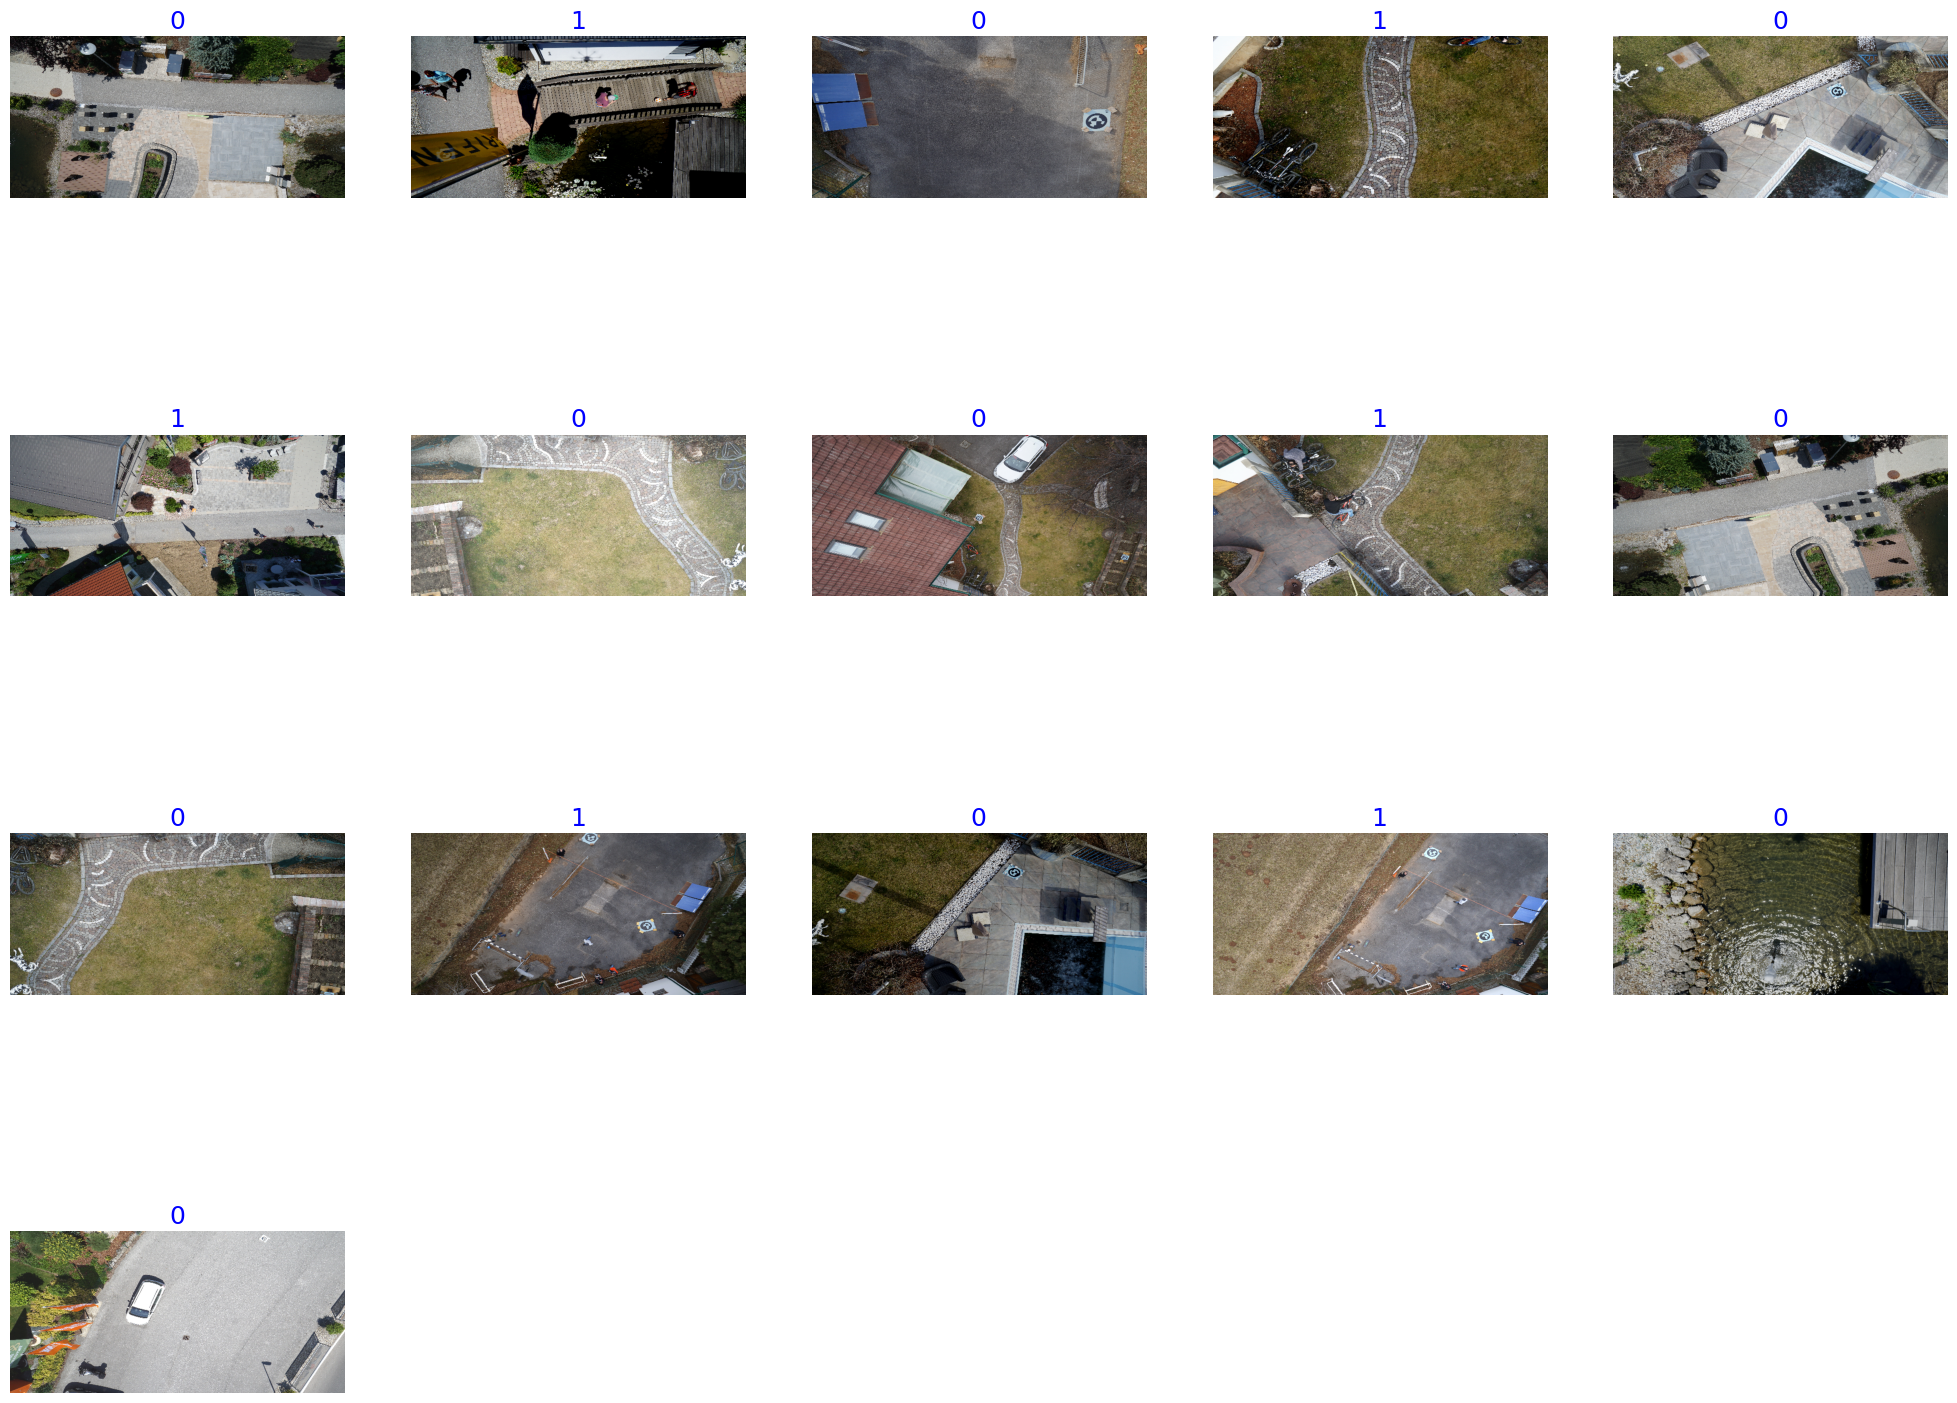

In [38]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [39]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [40]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

<a id="7"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Initialize a Model</b></div>

Here, we import a model for semantic segmentation, for which we need information as to the number of classes of objects and the data size.

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

def make_model(img_size, lr, mod_num=None):
    img_shape = (img_size[0], img_size[1], 3)

    # Using ResNet50 as the base model
    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    msg = 'Created ResNet50 model'

    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=.4, seed=123)(x)
    output = Dense(class_count, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Evidential Begins
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])  # Assuming you have defined F1_score or you can remove it
    msg = msg + f' with initial learning rate set to {lr}'
    print(msg)  # We use this function instead of print_in_color
    print_in_color(msg)
    return model

lr = .001
img_size = (224, 224)  # This is the standard ResNet50 image size
model = make_model(img_size, lr)


94765736/94765736 [==============================] - 3s 0us/step
Created ResNet50 model with initial learning rate set to 0.001
Created ResNet50 model with initial learning rate set to 0.001



In [42]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

<a id="8"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Trainnig and model fit
</b></div>

In [43]:
epochs = 20
ask_epoch = 2
ask=LR_ASK(model, epochs,  ask_epoch)

In [ ]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/20
125/125 [==============================] - 559s 4s/step - loss: 6.8652 - accuracy: 0.8820 - F1_score: 0.8820 - auc: 0.9355 - val_loss: 12.5870 - val_accuracy: 0.9250 - val_F1_score: 0.9167 - val_auc: 0.9613
Epoch 2/20
125/125 [==============================] - 570s 5s/step - loss: 4.6872 - accuracy: 0.9725 - F1_score: 0.9725 - auc: 0.9919 - val_loss: 4.9926 - val_accuracy: 0.9000 - val_F1_score: 0.8958 - val_auc: 0.9388
Epoch 3/20
125/125 [==============================] - 514s 4s/step - loss: 3.5615 - accuracy: 0.9905 - F1_score: 0.9905 - auc: 0.9991 - val_loss: 3.3473 - val_accuracy: 0.8750 - val_F1_score: 0.8750 - val_auc: 0.9663
Epoch 4/20
125/125 [==============================] - 521s 4s/step - loss: 2.8096 - accuracy: 0.9910 - F1_score: 0.9910 - auc: 0.9993 - val_loss: 2.8509 - val_accuracy: 0.9000 - val_F1_score: 0.8958 - val_auc: 0.9375
Epoch 5/20
125/125 [==============================] - 517s 4s/step - loss: 2.2504 - accuracy: 0.9910 - F1_score: 0.9910 - auc: 0.99

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

<a id="9"></a>
# <div style="padding:10px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:left;display:fill;border-radius:8px;background-color:#112A90;overflow:hidden"><b>Model Evaluation</b></div>

In [ ]:
def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [ ]:
print("Final AUC value for Training: ", history.history['auc'][-1])
print("Final AUC value for Validation: ", history.history['val_auc'][-1])

In [ ]:
max_val_auc = max(history.history['val_auc'])
print(f"Maximum Validation AUC: {max_val_auc:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_results(errors, tests):
    correct_preds = tests - errors
    labels = ['Correct Predictions', 'Errors']
    counts = [correct_preds, errors]

    plt.bar(labels, counts, color=['green', 'red'])
    plt.ylabel('Count')
    plt.title('Prediction Results')
    for i, v in enumerate(counts):
        plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
    plt.show()

plot_results(errors, tests)



In [ ]:
def plot_error_distribution(error_pred_list, classes):
    from collections import Counter
    error_counts = Counter(error_pred_list)
    labels = classes
    sizes = [error_counts.get(cls, 0) for cls in classes]

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of Errors among Classes')
    plt.show()

plot_error_distribution(error_pred_list, classes)



In [ ]:
def display_misclassified_images(test_gen, error_list, error_pred_list, num_images=10):

    """
     Display wrongly detected images

     Parameters:
     - test_gen: test data generator
     - error_list: a list of wrongly detected file names
     - error_pred_list: list of wrong predictions
     - num_images: the number of images you want to display
     """

    # To avoid displaying too many images
    if len(error_list) < num_images:
        num_images = len(error_list)

    fig = plt.figure(figsize=(20, 5))
    for i, file in enumerate(error_list[:num_images]):
        img = plt.imread(test_gen.directory + '/' + file)
        fig.add_subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Predicted: {error_pred_list[i]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display the wrongly detected images
display_misclassified_images(test_gen, error_list, error_pred_list)